[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1lbFGpK5NuACl49sfhTEzlBVEbUIsM_cV)


# Обучение

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
import random 
from matplotlib import pyplot as plt
random.seed(51)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/1c/seasons'

## Реализация необходимых функций

In [ ]:
def set_parameter_requires_grad(model, feature_extract, num_layers):
    if feature_extract:
        for param in list(model.parameters())[:(-1 * num_layers)]:
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model = None
    input_size = 0

    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "resnet-50":
        model = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        model = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model, input_size


In [ ]:
def create_data_transforms(input_size, scale = 1):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([int(scale * input_size), int(scale * input_size)]),
            transforms.RandomCrop(input_size),
            transforms.ColorJitter(0.5, 0.5, 0.5),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize([input_size, input_size]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms

In [ ]:
def create_train_val_datasets(path, data_transforms, split=0.8):
    train_dataset = torchvision.datasets.ImageFolder(path,  transform=data_transforms['train'])
    val_dataset = torchvision.datasets.ImageFolder(path,  transform=data_transforms['val'])
    
    indexes = list(range(len(train_dataset)))
    print(len(indexes))
    random.shuffle(indexes)
    indexes_train = indexes[:int(len(train_dataset)*split)]
    indexes_val = indexes[int(len(train_dataset)*split):]
    
    train_dataset_tf = torch.utils.data.Subset(train_dataset, indexes_train)
    val_dataset_tf = torch.utils.data.Subset(val_dataset, indexes_val)

    assert( len(indexes_val) + len(indexes_train) == len(train_dataset))
    
    return train_dataset_tf, val_dataset_tf

In [ ]:
import time
import copy
import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    history = {'train_acc' : [],
               'val_acc' : [],
               'train_loss': [],
               'val_loss': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            
            if phase == 'val' and epoch_acc >= best_acc and epoch > 5:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            history[phase + '_acc'].append(epoch_acc)
            history[phase + '_loss'].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history

## Инициализация модели и создание датасетов

In [ ]:
num_clases = 4
name = 'resnet'
feature_extract = True

model, input_size = initialize_model(name, num_clases, feature_extract=True)
set_parameter_requires_grad(model, feature_extract=feature_extract, num_layers=5)

data_transforms = create_data_transforms(input_size, scale=1.5)
train_dataset, val_dataset = create_train_val_datasets(path, data_transforms)

print(model)

307
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [ ]:
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

Params to learn:
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


## Обучение модели

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
optimizer_ft = torch.optim.Adam(params_to_update, lr=0.0005, weight_decay=0.001)

In [ ]:
batch_size = 16
shuffle = True
feature_extract = True

image_datasets = {'train': train_dataset,
                 'val': val_dataset}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, shuffle=shuffle, 
                                                   num_workers=2) for x in ['train', 'val']}

criterion = nn.CrossEntropyLoss()

model = model.to(device)

model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, 
                             num_epochs=30)

Epoch 0/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.7749 Acc: 0.7102


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


val Loss: 0.6882 Acc: 0.6774

Epoch 1/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.3660 Acc: 0.8612


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


val Loss: 0.4342 Acc: 0.8065

Epoch 2/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.2720 Acc: 0.9184


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.3297 Acc: 0.8387

Epoch 3/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.2484 Acc: 0.9388


100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


val Loss: 0.2822 Acc: 0.9032

Epoch 4/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.2079 Acc: 0.9306


100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


val Loss: 0.2638 Acc: 0.9355

Epoch 5/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


train Loss: 0.1799 Acc: 0.9388


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


val Loss: 0.2819 Acc: 0.9032

Epoch 6/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.1815 Acc: 0.9469


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.2785 Acc: 0.9194

Epoch 7/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.2041 Acc: 0.9224


100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.2446 Acc: 0.8871

Epoch 8/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.1465 Acc: 0.9592


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.2274 Acc: 0.9355

Epoch 9/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.1545 Acc: 0.9429


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.2458 Acc: 0.9194

Epoch 10/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.1062 Acc: 0.9714


100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


val Loss: 0.2822 Acc: 0.9194

Epoch 11/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1334 Acc: 0.9633


100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


val Loss: 0.3011 Acc: 0.9355

Epoch 12/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


train Loss: 0.1882 Acc: 0.9224


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.2484 Acc: 0.9194

Epoch 13/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.1434 Acc: 0.9592


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


val Loss: 0.1958 Acc: 0.9194

Epoch 14/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.1162 Acc: 0.9673


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.3938 Acc: 0.8548

Epoch 15/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


train Loss: 0.1495 Acc: 0.9469


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


val Loss: 0.2356 Acc: 0.9516

Epoch 16/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


train Loss: 0.1078 Acc: 0.9714


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


val Loss: 0.2394 Acc: 0.9516

Epoch 17/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.0855 Acc: 0.9673


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


val Loss: 0.2754 Acc: 0.9194

Epoch 18/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


train Loss: 0.1149 Acc: 0.9551


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.2806 Acc: 0.9355

Epoch 19/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.0826 Acc: 0.9755


100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


val Loss: 0.2682 Acc: 0.8871

Epoch 20/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


train Loss: 0.0713 Acc: 0.9755


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.2753 Acc: 0.9194

Epoch 21/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


train Loss: 0.0993 Acc: 0.9796


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.2183 Acc: 0.9516

Epoch 22/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.1298 Acc: 0.9592


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


val Loss: 0.3127 Acc: 0.9194

Epoch 23/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.1031 Acc: 0.9592


100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.3106 Acc: 0.8710

Epoch 24/29
----------


100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


train Loss: 0.1149 Acc: 0.9592


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


val Loss: 0.2839 Acc: 0.9355

Epoch 25/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.1200 Acc: 0.9673


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.3609 Acc: 0.8710

Epoch 26/29
----------


100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


train Loss: 0.1205 Acc: 0.9551


100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.3357 Acc: 0.8387

Epoch 27/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.1761 Acc: 0.9224


100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


val Loss: 0.3040 Acc: 0.8871

Epoch 28/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.1479 Acc: 0.9388


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.3120 Acc: 0.8871

Epoch 29/29
----------


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.0719 Acc: 0.9837


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

val Loss: 0.3039 Acc: 0.8871

Training complete in 5m 2s
Best val Acc: 0.951613


In [ ]:
torch.save(model, '/content/drive/MyDrive/1c/seasons/resnet.pth')

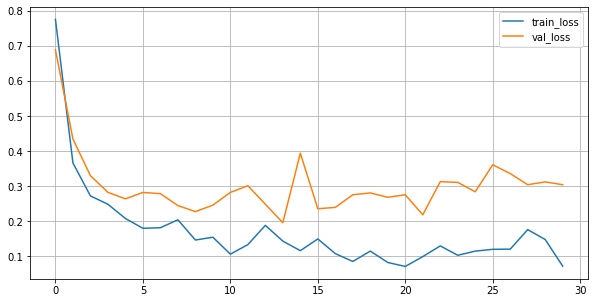

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(30),hist['train_loss'], label='train_loss')
plt.plot(range(30),hist['val_loss'], label='val_loss')
plt.legend()
plt.grid()

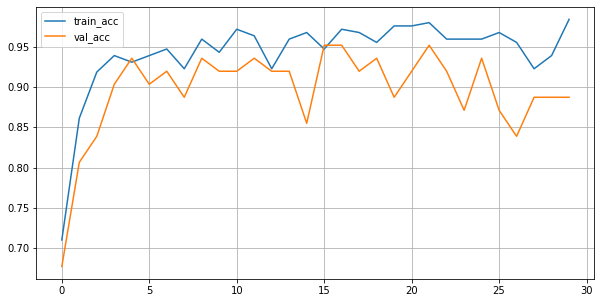

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(30),hist['train_acc'], label='train_acc')
plt.plot(range(30),hist['val_acc'], label='val_acc')
plt.legend()
plt.grid()

# Предсказание на собственных данных

In [23]:
import torch
from torchvision import transforms, models
import numpy as np
from PIL import Image

In [11]:
#скачивание модели с гугл диска
!gdown --id 1-AWhe7v1s30osMsY95DWJ8u96RHstp64

Downloading...
From: https://drive.google.com/uc?id=1-AWhe7v1s30osMsY95DWJ8u96RHstp64
To: /content/resnet.pth
100% 44.8M/44.8M [00:00<00:00, 205MB/s]


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('resnet.pth', map_location=device)

input_size = 224

data_transform = transforms.Compose([
            transforms.Resize([input_size, input_size]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [30]:
def predict_image(model, image):
    image_tensor = data_transform(image).float()
    image_tensor = image_tensor.unsqueeze(0)
    input = image_tensor.to(device)
    output = model(input)
    output = output.data.cpu().numpy()[0]
    print(output)
    index = output.argmax()
    prob = np.exp(output[index]) / sum(np.exp(output))
    return index, prob

In [14]:
from google.colab import files
uploded = files.upload()

Saving download (8).jpeg to download (8).jpeg
Saving download (7).jpeg to download (7) (1).jpeg
Saving kartinki-zolotaya-osen-4.jpg to kartinki-zolotaya-osen-4 (1).jpg
Saving 5407182a8b5420a272237a35bcd05275.jpeg to 5407182a8b5420a272237a35bcd05275 (1).jpeg
Saving i (1).jpeg to i (1) (1).jpeg
Saving i.jpeg to i (3).jpeg


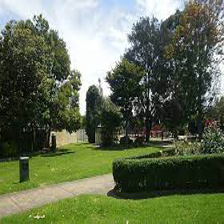

[-1.9659841  1.0464952  4.9439034 -8.028605 ]
Predicted class: summer with probability 0.979


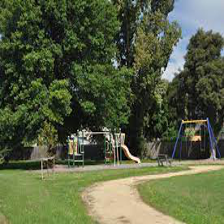

[-1.3580278  -0.56246376  4.1156344  -5.086165  ]
Predicted class: summer with probability 0.987


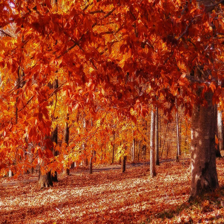

[ 6.7205467 -5.421335  -4.947932   0.9978197]
Predicted class: autumn with probability 0.997


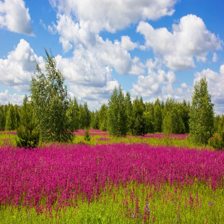

[-4.2614646  2.0888305  6.295233  -7.579902 ]
Predicted class: summer with probability 0.985


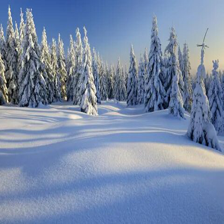

[-6.1673765 -1.1775835 -2.547986   6.571172 ]
Predicted class: winter with probability 0.999


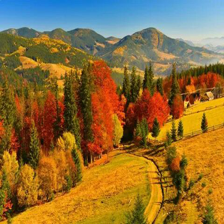

[ 4.166385  -2.3353846  2.9623098 -8.941006 ]
Predicted class: autumn with probability 0.768


In [37]:
from PIL import Image
seasons= {0 : 'autumn',
          1 : 'spring',
          2 : 'summer',
          3 : 'winter'}

for img in uploded.keys():
  image = Image.open(img)
  display(image.resize((224,224)))
  answer =  predict_image(model, image)
  print('Predicted class:', seasons[answer[0]], 
        "with probability {:.3f}".format(round(answer[1], 3)))